In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
path = os.path.join(os.getcwd(), os.pardir)
sys.path.append(path)

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import norm, skew, mode
from sklearn import metrics
import matplotlib.pyplot as plt
import pylab as py
from BAI import environment, solver, analysis

In [3]:
plt.rcParams['figure.figsize'] = [10, 6]

# Simulation 2-1 Setup (Gaussian 500-BatchSize)

In [4]:
K = 3
K_H0 = 3
gamma = 0.01 * K
n_bandits = 2
n_parallels = n_bandits * 50000
n_batches = 1
batch_func = environment.func_constant_batch(10000)
variance = [1 for i in range(K)]
lst_bandit_alter = []
lst_bandit_null = []
lst_thetas_alter = []
lst_thetas_null = []
for _ in range(n_bandits//2):
    # H1 is True - Low Signal
    thetas = np.sort(np.random.normal(0, 1, K))[::-1]
    reward_func_alter = environment.func_gaussian_reward(thetas, variance)
    bandit_alter = environment.Bandit(K=K, reward_func=reward_func_alter, batch_func=batch_func)
    lst_bandit_alter.append(bandit_alter)
    lst_thetas_alter.append(thetas)
    # H0 is True - Low Signal
    # thetas = np.sort(np.random.normal(0, 1, K-K_H0+1))[::-1]
    # best_mu = max(thetas)
    # for _ in range(K_H0-1):
    #     thetas = np.insert(thetas, 1, best_mu)
    thetas = [1 for _ in range(K_H0)]
    reward_func_null = environment.func_gaussian_reward(thetas, variance)
    bandit_null = environment.Bandit(K=K, reward_func=reward_func_null, batch_func=batch_func)
    lst_bandit_null.append(bandit_null)
    lst_thetas_null.append(thetas)

In [5]:
print("H0")
for each in lst_thetas_null:
    print(each)
print("H1")
for each in lst_thetas_alter:
    print(each)

H0
[1, 1, 1]
H1
[ 0.9012167   0.23397289 -1.90846569]


# UNIF

In [6]:
eta = 1

In [7]:
G = 5000
beta = 0.5
tracking_history = []
for parallel_idx in range(n_parallels):
    null_vs_alter = 1
    bandit = lst_bandit_null[0]
    # bandit_choice = parallel_idx % n_bandits
    # null_vs_alter = bandit_choice
    # if bandit_choice >= n_bandits//2:
    #     bandit = lst_bandit_null[bandit_choice - n_bandits//2]
    # elif bandit_choice < n_bandits//2:
    #     bandit = lst_bandit_alter[bandit_choice]
    trials = [0 for i in range(K)]
    rewards = [0 for i in range(K)]
    mus_nb = [0 for i in range(K)]
    mus_wb = [0 for i in range(K)]
    lambdas = [0 for i in range(K)]
    numerator = [0 for i in range(K)]
    denominator = [0 for i in range(K)]
    batch_count = [0 for i in range(K)]
    # cal sample variance
    SS = [0 for _ in range(K)]
    sample_variance_nb = [1 for _ in range(K)]
    sample_variance_wb = [1 for _ in range(K)]
    sampling_probs = [1 / K for i in range(K)]
    for batch_idx in range(n_batches):
        batch_feedback = bandit.batch_observe_fast(
            sampling_distrib = sampling_probs, 
            time_index=batch_idx
        )
        for arm_idx in range(K):
            batch_trials = batch_feedback['trials'][arm_idx]
            if batch_trials > 0:
                trials[arm_idx] += batch_trials
                rewards[arm_idx] += batch_feedback['rewards'][arm_idx]
                # update batch info
                batch_count[arm_idx] += 1
                denominator[arm_idx] += np.sqrt(batch_trials)
                numerator[arm_idx] += batch_feedback['rewards'][arm_idx] / np.sqrt(batch_trials)
                # initial prior by first batch or update posterior
                lambdas[arm_idx] =  eta * denominator[arm_idx]**2 / batch_count[arm_idx]
                mus_wb[arm_idx] = numerator[arm_idx] / denominator[arm_idx]
                mus_nb[arm_idx] = rewards[arm_idx] / trials[arm_idx]
                # cal sample variance
                SS[arm_idx] += batch_feedback['squared_rewards'][arm_idx]
                sample_variance_nb[arm_idx] = SS[arm_idx] / trials[arm_idx] - mus_nb[arm_idx]**2
                sample_variance_wb[arm_idx] = SS[arm_idx] / trials[arm_idx] - mus_wb[arm_idx]**2
        # weighted batched
        mc_sampling = np.array([np.random.normal(mus_wb[i], np.sqrt(sample_variance_wb[i]/lambdas[i]), G) for i in range(K)])
        mc_optimal_arm = np.argmax(mc_sampling, axis=0)
        wb_posterior_delta = np.mean(np.max(mc_sampling, axis=0) - mc_sampling, axis=1)
        wb_optimal_probs = [round(np.sum(np.where(mc_optimal_arm == arm_i, 1, 0)) / G, 4) for arm_i in range(K)]
        # naive batched
        mc_sampling = np.array([np.random.normal(mus_nb[i], np.sqrt(sample_variance_nb[i]/(eta * trials[i])), G) for i in range(K)])
        mc_optimal_arm = np.argmax(mc_sampling, axis=0)
        nb_posterior_delta = np.mean(np.max(mc_sampling, axis=0) - mc_sampling, axis=1)
        nb_optimal_probs = [round(np.sum(np.where(mc_optimal_arm == arm_i, 1, 0)) / G, 4) for arm_i in range(K)]
        # tracking history and analysis
        for arm_idx in range(K):
            tracking_reccord = (
                parallel_idx,
                null_vs_alter,
                batch_idx,
                arm_idx,
                sampling_probs[arm_idx],
                mus_nb[arm_idx],
                trials[arm_idx],
                sample_variance_nb[arm_idx],
                nb_optimal_probs[arm_idx],
                nb_posterior_delta[arm_idx],
                mus_wb[arm_idx],
                lambdas[arm_idx],
                sample_variance_wb[arm_idx],
                wb_optimal_probs[arm_idx],
                wb_posterior_delta[arm_idx],
                trials[arm_idx] / sum(trials)
            )
            tracking_history.append(tracking_reccord)
        # change traffic
        # optimal_odds = [wb_optimal_probs[i] / (1 - wb_optimal_probs[i]) if wb_optimal_probs[i] < 1 else 99 for i in range(K)]
        # sampling_probs = [wb_optimal_probs[i] * (beta + (1 - beta) * (np.sum(optimal_odds) - optimal_odds[i])) for i in range(K)]
        # sampling_probs = [sampling_probs[i] / np.sum(sampling_probs) for i in range(K)]
        # sampling_probs = [(1 - gamma) * sampling_probs[i] + gamma * 1/K for i in range(K)]
# convert tracking_history to dataframe
df_UNIF = pd.DataFrame(tracking_history, columns=[
    'parallel_idx','null_vs_alter','batch_idx', 'arm_idx', 'sampling_prob', 
    'mu_nb', 'tau_nb', 'sample_variance_nb', 'optimal_prob_nb','posterior_delta_nb',
    'mu_wb', 'tau_wb', 'sample_variance_wb', 'optimal_prob_wb','posterior_delta_wb',
    'proportion_trials'
])

# Analysis

In [8]:
df_UNIF.query("parallel_idx==1 and arm_idx==0")

parallel_idx  null_vs_alter  batch_idx  arm_idx  sampling_prob     mu_nb  \
3             1              1          0        0       0.333333  1.005131   

   tau_nb  sample_variance_nb  optimal_prob_nb  posterior_delta_nb     mu_wb  \
3   20000             1.00429            0.148             0.01107  1.005131   

    tau_wb  sample_variance_wb  optimal_prob_wb  posterior_delta_wb  \
3  20000.0             1.00429           0.1536            0.010912   

   proportion_trials  
3           0.333333

In [9]:
start_idx = 0
type_I = 0.1
# FPR
th = 1 - (type_I/K_H0) ** (1/(K_H0-1))
print(th)
FPR_UNIF_WB = df_UNIF.query("null_vs_alter == 1 and batch_idx >= {}".format(start_idx)).groupby(['parallel_idx','batch_idx']).apply(
    lambda x: pd.Series([
        np.max(x.optimal_prob_wb)
    ])
).rename(columns={0:'max_optimal_prob'}).reset_index().groupby(['batch_idx']).apply(
    lambda x: pd.Series([
        np.mean(x.max_optimal_prob >= th)
    ])
).rename(columns={0:'FPR'}).reset_index()
# # Power and Regret
#     lambda x: pd.Series([
#         np.mean(x.optimal_prob_wb >= th),
#         np.mean(1 - x.proportion_trials),
#         np.std(1 - x.proportion_trials)
#     ])
# ).rename(columns={0:'recall', 1:'avg_regret', 2:'std_regret'}).reset_index()
# # Precision Under H1
# precision_h1_UNIF_WB = df_UNIF.query("null_vs_alter == 0 and optimal_prob_wb > {} and batch_idx >= {}".format(th, start_idx)).groupby(['batch_idx']).apply(
#     lambda x: pd.Series([
#         np.mean(x.arm_idx == 0)
#     ])
# ).rename(columns={0:'precision'}).reset_index()
# pd.DataFrame({
#     'sample_size': (FPR_UNIF_WB.batch_idx.values + 1) * 10000,
#     'FPR_UNIF_WB': FPR_UNIF_WB.FPR.values,
#     'recall_UNIF_WB': analysis_UNIF_WB.recall.values,
#     'precision_h1_UNIF_WB': precision_h1_UNIF_WB.precision.values
# })
FPR_UNIF_WB

0.8174258141649446


batch_idx      FPR
0          0  0.16822

In [68]:
start_idx = 0
DATA_UNIF_WB = df_UNIF.query("null_vs_alter == 1 and batch_idx >= {}".format(start_idx)).groupby(['parallel_idx','batch_idx']).apply(
    lambda x: pd.Series([
        np.max(x.optimal_prob_wb)
    ])
).rename(columns={0:'max_optimal_prob'}).reset_index()

In [90]:
type_I = 0.2
# FPR
th = 1 - (type_I/K_H0) ** (1/(K_H0-1))
print(th)
DATA_UNIF_WB.groupby(['batch_idx']).apply(
    lambda x: pd.Series([
        np.mean(x.max_optimal_prob > th)
    ])
).rename(columns={0:'FPR'}).reset_index()

0.7418011102528389


batch_idx      FPR
0          0  0.28198

In [10]:
alpha_analysis = df_UNIF.query('null_vs_alter == 1').groupby(['null_vs_alter', 'batch_idx']).apply(
    lambda x: pd.Series([
        np.mean(x.optimal_prob_wb[x.arm_idx == 0]),
        np.var(x.optimal_prob_wb[x.arm_idx == 0]),
        np.mean(x.optimal_prob_wb[x.arm_idx == 1]),
        np.var(x.optimal_prob_wb[x.arm_idx == 1]),
        np.mean(x.optimal_prob_wb[x.arm_idx == 2]),
        np.var(x.optimal_prob_wb[x.arm_idx == 2]),
        np.mean(x.optimal_prob_wb[x.arm_idx == 3]),
        np.var(x.optimal_prob_wb[x.arm_idx == 3])
    ])
).rename(columns={
    0:'alpha_1',1:'alpha_var_1',
    2:'alpha_2',3:'alpha_var_2',
    4:'alpha_3',5:'alpha_var_3',
    6:'alpha_4',7:'alpha_var_4'
}).reset_index()
alpha_analysis

null_vs_alter  batch_idx   alpha_1  alpha_var_1   alpha_2  alpha_var_2  \
0              1          0  0.334432     0.067503  0.333125      0.06723   

    alpha_3  alpha_var_3  alpha_4  alpha_var_4  
0  0.332442     0.067099      NaN          NaN

In [11]:
alpha_analysis.alpha_1 * (1 - alpha_analysis.alpha_1) / alpha_analysis.alpha_var_1 - 1

0    2.297426
dtype: float64

# Case

In [12]:
# http://blog.bogatron.net/blog/2014/02/02/visualizing-dirichlet-distributions/
# https://chart-studio.plotly.com/~david_avakian/14.embed
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
AREA = 0.5 * 1 * 0.75**0.5
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

# For each corner of the triangle, the pair of other corners
pairs = [corners[np.roll(range(3), -i)[1:]] for i in range(3)]
# The area of the triangle formed by point xy and another pair or points
tri_area = lambda xy, pair: 0.5 * np.linalg.norm(np.cross(*(pair - xy)))

def xy2bc(xy, tol=1.e-4):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    coords = np.array([tri_area(xy, p) for p in pairs]) / AREA
    return np.clip(coords, tol, 1.0 - tol)

def bc2xy(bc_coords, tol=1.e-4):
    '''Converts barycentric to 2D Cartesian coordinates'''
    bc_coords = np.clip(bc_coords, tol, 1.0 - tol)
    xy_coords = corners.T.dot(bc_coords)
    return xy_coords

class Dirichlet(object):
    def __init__(self, alpha):
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / \
                           np.multiply.reduce([gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * np.multiply.reduce([xx ** (aa - 1)
                                               for (xx, aa)in zip(x, self._alpha)])

In [49]:
def draw_pdf_contours(dist, nlevels=200, subdiv=8, samples=None,**kwargs):
    import math

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, cmap='plasma', **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.colorbar()
    plt.axis('off')
    plt.title(r'Distribution of $(\alpha_1,\alpha_2,\alpha_3)$', fontsize=25, usetex = True);
    plt.text(-0.06, 0.01, r'$\alpha_1$', fontsize=20);
    plt.text(1.0, 0.01, r'$\alpha_2$', fontsize=20);
    plt.text(0.52, 0.83, r'$\alpha_3$', fontsize=20);

    if samples is not None:
        points = np.array([bc2xy(bc) for bc in samples])
        plt.scatter(points[:,0], points[:,1], alpha=0.1, s=1, c='grey');

In [32]:
def draw_sample_contours(dist, nlevels=200, subdiv=8, samples=None,**kwargs):
    import math

    plt.plot((0, 0.5), (0, 0.87), marker = 'o', color='black')
    plt.plot((0, 1), (0, 0), marker = 'o', color='black')
    plt.plot((1, 0.5), (0, 0.87), marker = 'o', color='black')

    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    # plt.colorbar()
    plt.axis('off')
    plt.title(r'Distribution of $(\alpha_1,\alpha_2,\alpha_3)$', fontsize=25, usetex = True);
    plt.text(-0.06, 0.01, r'$\alpha_1$', fontsize=20);
    plt.text(1.0, 0.01, r'$\alpha_2$', fontsize=20);
    plt.text(0.52, 0.83, r'$\alpha_3$', fontsize=20);

    if samples is not None:
        points = np.array([bc2xy(bc) for bc in samples])
        plt.scatter(points[:,0], points[:,1], alpha=1, s=1, c='grey');

In [62]:
arm_1 = alpha_analysis.alpha_1.values
var_arm_1 = alpha_analysis.alpha_var_1.values
arm_2 = alpha_analysis.alpha_2.values
var_arm_2 = alpha_analysis.alpha_var_2.values
arm_3 = alpha_analysis.alpha_3.values
var_arm_3 = alpha_analysis.alpha_var_3.values
lst_a0_1 = arm_1 * (1-arm_1)/var_arm_1 - 1
lst_a0_2 = arm_2 * (1-arm_1)/var_arm_2 - 1
lst_a0_3 = arm_3 * (1-arm_1)/var_arm_3 - 1

batch_idx = 0
print(
    arm_1[batch_idx],arm_2[batch_idx],arm_3[batch_idx], 
    lst_a0_1[batch_idx],lst_a0_2[batch_idx],lst_a0_3[batch_idx],
    np.mean([lst_a0_1[batch_idx],lst_a0_2[batch_idx],lst_a0_3[batch_idx]])
)
a0 = np.mean([lst_a0_1[batch_idx],lst_a0_2[batch_idx],lst_a0_3[batch_idx]])

0.334432488 0.33312547200000003 0.33244204 2.297426107319789 2.2979068977409627 2.2975424165067 2.297625140522484


In [63]:
sim_values = list(df_UNIF.query("null_vs_alter==1 and batch_idx=={}".format(batch_idx)).groupby('parallel_idx').apply(lambda x: x.optimal_prob_wb.tolist()))

[0.76840049 0.76539746 0.76382719]


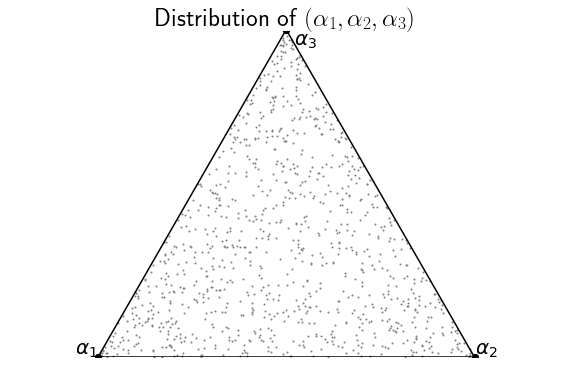

In [64]:
alpha = np.array([arm_1[batch_idx],arm_2[batch_idx],arm_3[batch_idx]])
print(alpha * a0)
draw_sample_contours(Dirichlet(alpha * a0), subdiv=4, samples=sim_values[0:1000], alpha=0.8)

2.297625140522484


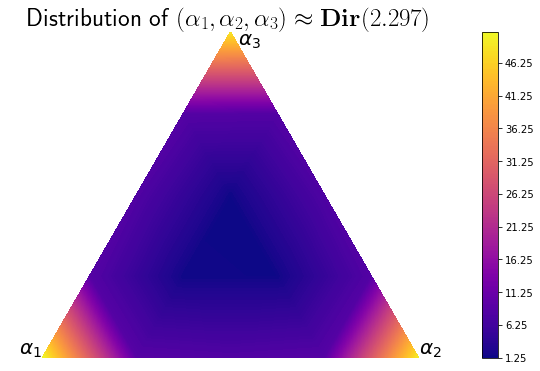

In [65]:
alpha = np.array([arm_1[batch_idx],arm_2[batch_idx],arm_3[batch_idx]])
print(a0)
draw_pdf_contours(Dirichlet(alpha * a0), subdiv=2, samples=None, alpha=1)
plt.title(r'Distribution of $(\alpha_1,\alpha_2,\alpha_3) \approx \mathbf{Dir}(2.297)$', fontsize=25, usetex = True);

In [66]:
from scipy.stats import beta
# beta_a = alpha * (a0 - 2) + 1
beta_a = alpha * a0
beta_b = a0 - beta_a
print(beta_a, beta_b)

# x = np.linspace(0,1, 100)
# plt.figure(figsize=(7,7))
# plt.xlim(0, 1)
# plt.plot(x, beta.pdf(x, beta_a[0], beta_b[0]), 'r-')
# plt.title('Beta Distribution', fontsize='15')
# plt.show()

[0.76840049 0.76539746 0.76382719] [1.52922465 1.53222768 1.53379795]


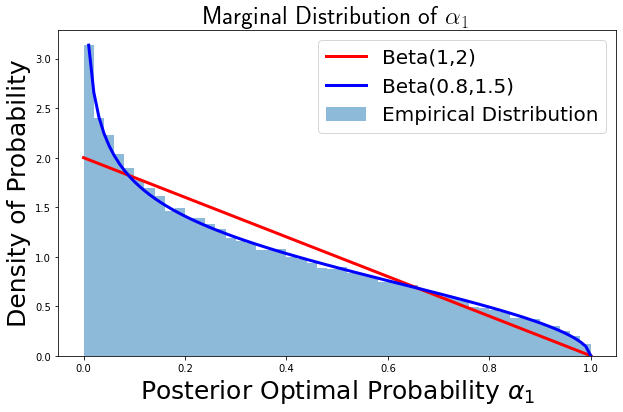

In [67]:
values = df_UNIF.query("arm_idx == 0 and null_vs_alter == 1 and batch_idx == {}".format(batch_idx)).optimal_prob_wb

plt.hist(values, alpha=0.5, bins=50, density=True, label='Empirical Distribution');
x_values = np.linspace(0, 1, 100)
plt.plot(x_values, beta.pdf(x_values, 1, 2), color='red', alpha=1, lw=3, label=r'Beta({},{})'.format(1, 2));
plt.plot(x_values, beta.pdf(x_values, round(beta_a[0],2), round(beta_b[0], 2)), color='blue', alpha=1, lw=3, label=r'Beta({},{})'.format(round(beta_a[0],1), round(beta_b[0], 1)));

plt.title(r'Marginal Distribution of $\alpha_1$', fontsize=25, usetex = True);
plt.xlabel(r'Posterior Optimal Probability $\alpha_1$', fontsize=25);
plt.ylabel(r'Density of Probability', fontsize=25)
# plt.legend(fontsize=20, loc='lower left')
plt.legend(fontsize=20, loc='upper right')